In [56]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numba
from time import perf_counter
from scipy.ndimage import convolve, sobel
from scipy import ndimage
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline
sns.set_style("ticks")
sns.set_context("poster")

def timer(method):
    def timed(*args, **kw):
        ts = perf_counter()
        result = method(*args, **kw)
        te = perf_counter()
        tlapsed = te-ts
        print(f"{tlapsed//60} mins and {tlapsed%60:0.2f} secs")
        return result
    return timed

In [36]:
# def grierer_meinhardt(U, V, Du, Dv, c1, c2, c3, c4, c5, k, dt, dx, T, sr=5):
#     n = U.shape[0]
#     iters = int(T / dt)
#     for i in tqdm(range(iters)):
#         Lu = Du*lap_neumann(U)/dx/dx
#         Lv = Dv*lap_neumann(V)/dx/dx
#         uc = U[1:-1, 1:-1]
#         vc = V[1:-1, 1:-1]
#         U[1:-1, 1:-1], V[1:-1, 1:-1] =\
#         uc + dt*(Lu + c1 - c2*uc + c3*uc*uc/(1+k*uc*uc)/vc),\
#         vc + dt*(Lv + c4*uc*uc - c5*vc)
#         for u in (U, V):
#             u[0, :] = u[1, :]
#             u[-1, :] = u[-2, :]
#             u[:, 0] = u[:, 1]
#             u[:, -1] = u[:, -2]
#     return U, V

@numba.njit(fastmath=True, parallel=True)
def gray_scott(U, V, Du, Dv, f, k, dt, dx, T):
    n = U.shape[0]
    iters = int(T / dt)
    for i in range(iters):
        Lu, Lv = Du*lap(U, n)/dx/dx, Dv*lap(V, n)/dx/dx
        U, V = U + dt*(Lu - U*V*V + f * (1-U)), V + dt*(Lv + U*V*V - (f+k) * V)
    return U, V

def lap_neumann(u):
    return u[:-2, 1:-1] + u[2:, 1:-1] + u[1:-1, :-2] + u[1:-1, 2:] - 4*u[1:-1, 1:-1]

@numba.njit(parallel=True, fastmath=True)
def lap(u, N):
    """
    Parallel implementation of the discrete heat equation. Loops over all
    rows in parallel.
    """
    uc = np.empty((N, N))
    for x in numba.prange(1, N-1):
        uc[x, 1:-1] = u[x+1, 1:-1] + u[x-1, 1:-1] + u[x, :-2] + u[x, 2:] - 4*u[x, 1:-1]

    uc[1:-1, 0] = u[1:-1, 1] + u[:-2, 0] + u[2:, 0] + u[1:-1, -1] - 4*u[1:-1, 0]
    uc[1:-1, -1] = u[1:-1, -2] + u[:-2, -1] + u[2:, -1] + u[1:-1, 0] - 4*u[1:-1, -1]
    uc[0, 1:-1] = u[1, 1:-1] + u[0, 2:] + u[0, :-2] + u[-1, 1:-1] - 4*u[0, 1:-1]
    uc[-1, 1:-1] = u[-2, 1:-1] + u[-1, 2:] + u[-1, :-2] + u[0, 1:-1] - 4*u[-1, 1:-1]

    uc[0, 0] = u[0, 1] + u[0, -1] + u[1, 0] + u[-1, 0] - 4*u[0, 0]
    uc[-1, 0] = u[0, 0] + u[-2, 0] + u[-1, -1] + u[-1, -2] - 4*u[-1, 0]
    uc[0, -1] = u[0, 0] + u[0, -2] + u[-1, -1] + u[1, -1] - 4*u[0, -1]
    uc[-1, -1] = u[0, -1] + u[-1, 0] + u[-1, -2] + u[-2, -1] - 4*u[-1, -1]
    return uc

def convolution(mat, kernel, rep=1):
    for _ in range(rep):
        mat = convolve(mat, kernel, mode='wrap')
    return mat

def comp_edginess(U, V, Du, Dv, F, k, dt, dx, T):
    U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
    r, m = n//40, n//2
    U[...] = 0.5
    edge3 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    V[m-r:m+r, m-r:m+r] = 0.25
    u_out, v_out = gray_scott(U, V, Du, Dv, F, k, dt, dx, T)
    convol = np.sum(convolution(u_out, edge3, 1))
    return convol

In [393]:
n = 200
Du = 0.16
Dv = 0.08
# F = 0.035
F_range = np.linspace(0.02, 0.07, 50)
k = 0.06
T = 10000
dt = 1.0
dx = 1.0

edginess = [comp_edginess(U, V, Du, Dv, F, k, dt, dx, T) for F in F_range]
plt.figure(figsize=(10,10))
plt.plot(F_range, edginess)
plt.xlabel("f")
plt.ylabel("edginess")
plt.show()

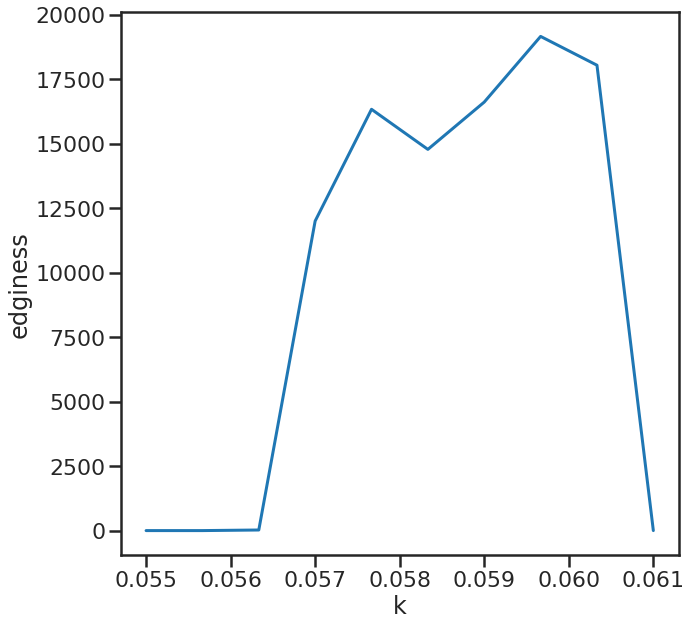

In [408]:
n = 150
Du = 0.16
Dv = 0.08
F = 0.035
k_range = np.linspace(0.055, 0.061, 10)
T = 10000
dt = 1.0
dx = 1.0

edginess = [comp_edginess(U, V, Du, Dv, F, k, dt, dx, T) for k in k_range]
plt.figure(figsize=(10,10))
plt.plot(k_range, edginess)
plt.xlabel("k")
plt.ylabel("edginess")
plt.show()

In [90]:
n = 250
Du = 0.16
Dv = 0.08
F = 0.035
k = 0.06
T = 10000
dt = 1.0
dx = 1.0


U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
r, m = n//40, n//2
U[...] = 0.5
edge3 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
V[m-r:m+r, m-r:m+r] = 0.25
u_out, v_out = gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

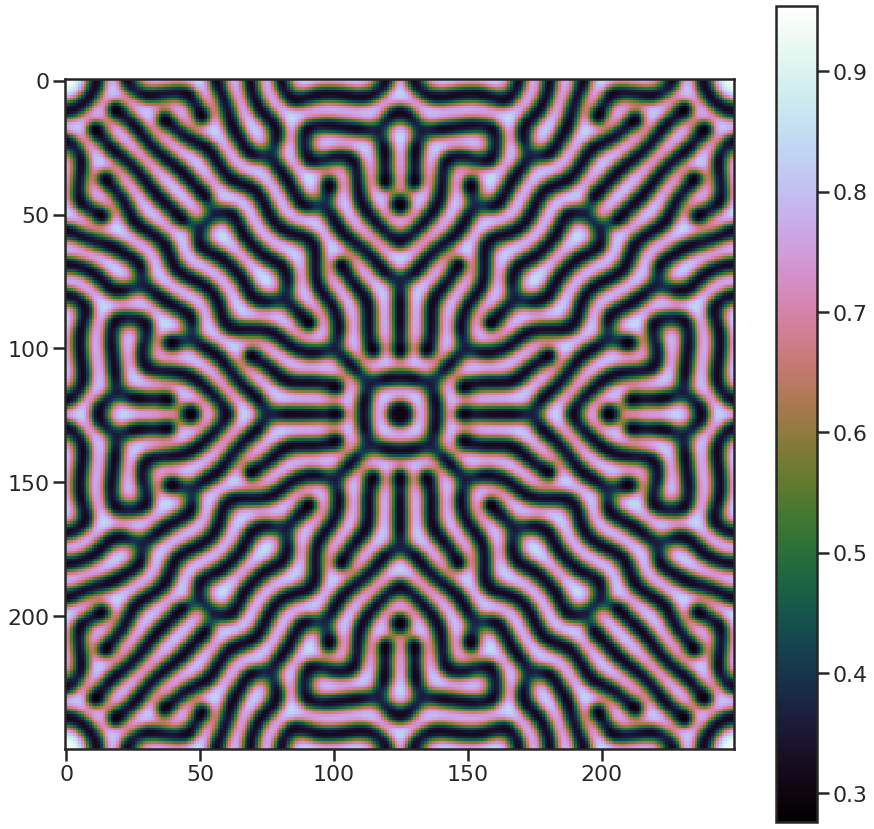

In [91]:
plt.figure(figsize=(15,15))
plt.imshow(u_out, cmap='cubehelix')
plt.colorbar()
plt.show()

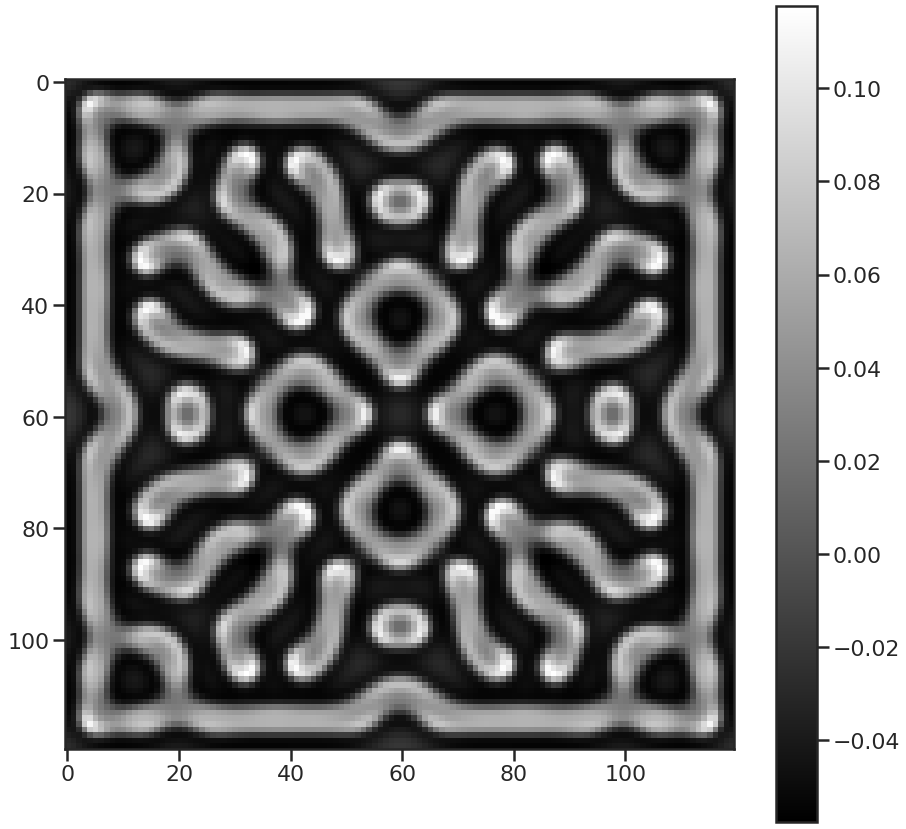

In [39]:
edge1 = np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1]])
edge2 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
edge3 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
plt.figure(figsize=(15,15))
plt.imshow(convolution(u_out, edge2, 1), cmap='gray')
plt.colorbar()
plt.show()

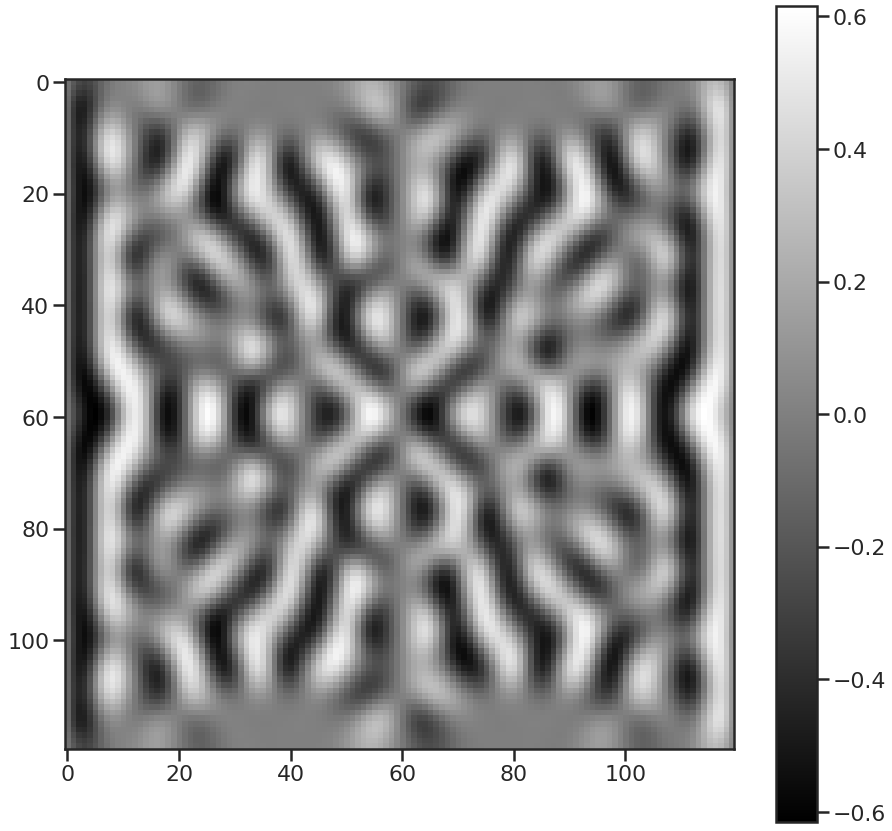

In [47]:
plt.figure(figsize=(15,15))
plt.imshow(ndimage.sobel(ndimage.gaussian_filter(u_out, sigma=2, mode='wrap'), mode='wrap'), cmap='gray')
plt.colorbar()
plt.show()

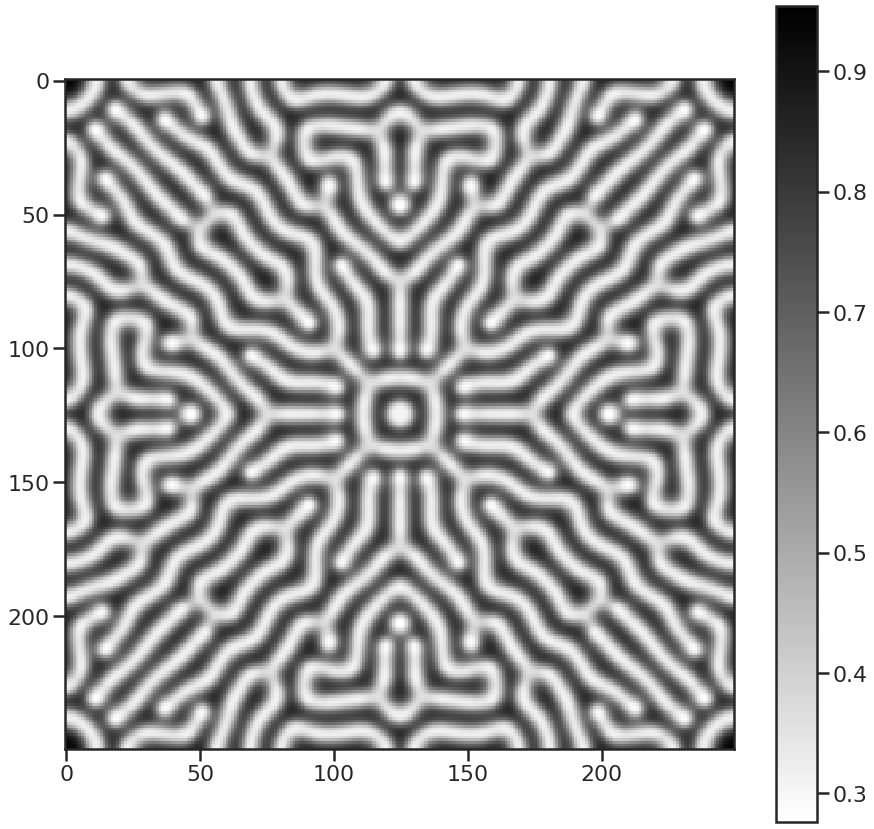

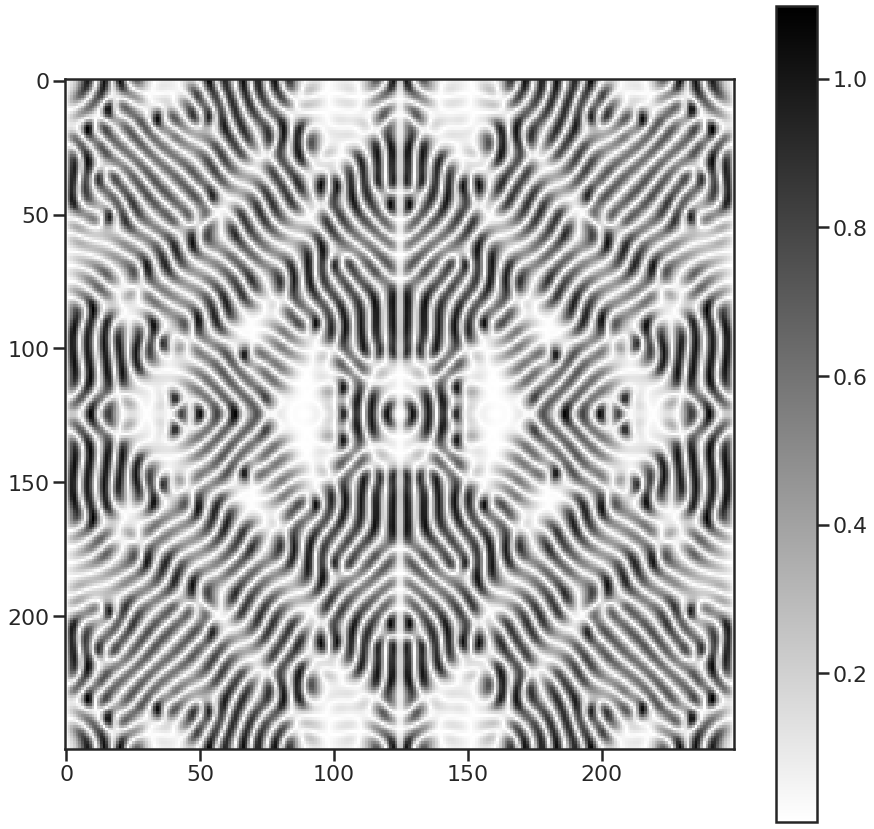

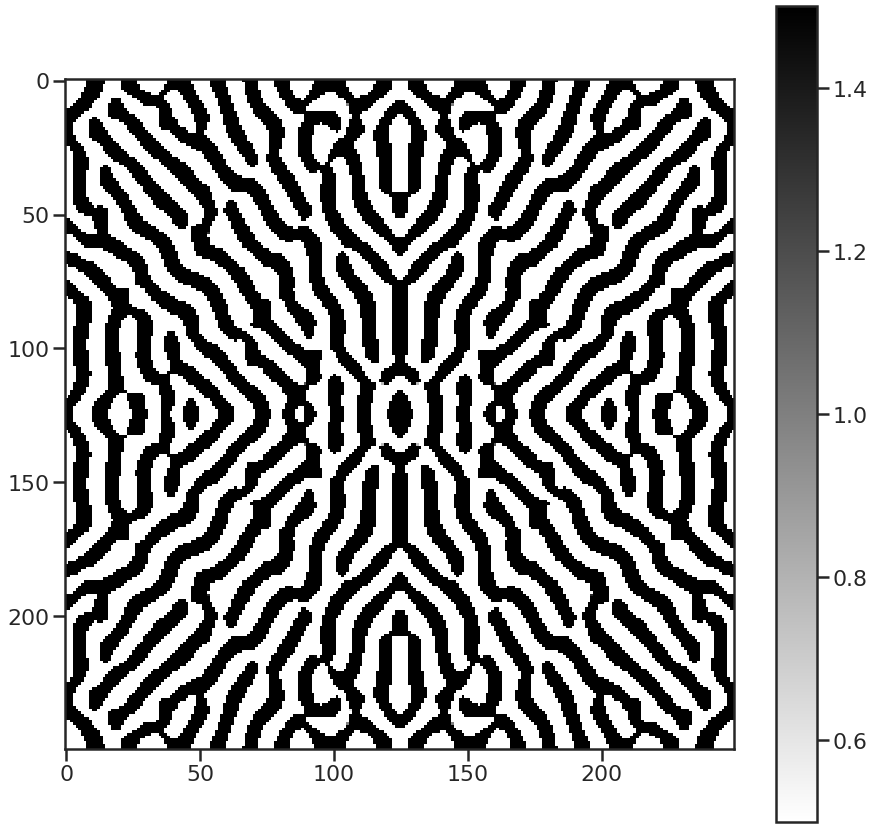

In [102]:
plt.figure(figsize=(15,15))
plt.imshow(u_out, cmap='binary')
plt.colorbar()
plt.show()

sobel1 = sobel(u_out, mode='wrap')

plt.figure(figsize=(15,15))
plt.imshow(np.abs(sobel1), cmap='binary')
plt.colorbar()
plt.show()

sobel2 = sobel(sobel(u_out, mode='wrap'))

plt.figure(figsize=(15,15))
plt.imshow(np.clip(sobel2*1000, 0.5, 1.5), cmap='binary')
plt.colorbar()
plt.show()

In [19]:
np.sum(u_out)

8019.079052377486

In [103]:
labels = ndimage.label(np.clip(sobel2*1000, 0, 1))

In [105]:
len(labels[0])

250

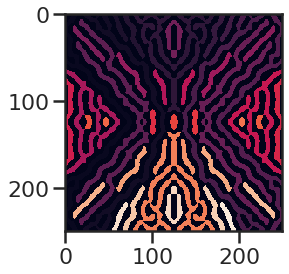

In [110]:
plt.imshow(labels[0])

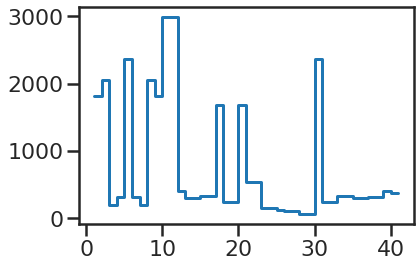

In [142]:
bins, edges = np.histogram(labels[0], bins=labels[1])
left,right = edges[:-1],edges[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([bins,bins]).T.flatten()
plt.plot(X[2:], Y[2:])

In [138]:
len(a)

41

In [139]:
len(b)

42